# <center> The guide to fundamental analysis </center>
<center> Quantitative analysis is an essential part of determine whether a company is a good potential investment. This program automates this process by quickly displaying the main insights required to assist the decision making and even provide potential stocks to research. Disclaimer: This is best implemented on developed comapnies stocks with atleast 5 years worth of financial data </center>

# <center> Stage 1 - Collect financial data </center>
<center> Use the simfin api to import financial data - note that the free version of the model provides data with a 12 month lag </center>

In [1]:
# Import  all required library packages
import matplotlib.pyplot as plt, pandas as pd
import simfin as sf, numpy as np, datetime, math
from simfin.names import *
from datetime import date

In [2]:
# Set a data directory to download and store data
sf.set_data_dir('~/simfin_data_all/')
# Use the free api key
sf.set_api_key(api_key='free')

In [3]:
                                    #Load financial statements
#Load the income statement
income_statement = sf.load(dataset='income',variant='annual', market='us',index=[TICKER], parse_dates=[REPORT_DATE, PUBLISH_DATE, RESTATED_DATE])
#Load the balance sheet
balance_sheet = sf.load(dataset='balance',variant='annual', market='us',index=[TICKER], parse_dates=[REPORT_DATE, PUBLISH_DATE, RESTATED_DATE])
#Load the cashflow statement
cashflow_Statement = sf.load(dataset='cashflow',variant='annual', market='us',index=[TICKER], parse_dates=[ PUBLISH_DATE, RESTATED_DATE])
#Load share prices
share_price = sf.load(dataset='shareprices',variant='daily', market='us',index=[TICKER], parse_dates=[DATE])
#Load company details
company_details = sf.load(dataset='companies',variant='annual', market='us', index=[TICKER])

Dataset "us-income-annual" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-balance-annual" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-annual" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-companies-annual" on disk (1 days old).
- Loading from disk ... Done!


# <center> Stage 2 - Company insights </center> 
<center> A walkingthrough highlighting the important company parameters </center>

In [4]:
#State the company to analyse
tckr = input('Enter the Ticker Symbol:')

In [5]:
# Extract the main parameters from the financial documents
revenue_df = income_statement.loc[tckr][REVENUE]
operating_cashflow_df = cashflow_Statement.loc[tckr]['Net Cash from Operating Activities']
ppe_df = balance_sheet.loc[tckr]['Property, Plant & Equipment, Net']
capex_df = cashflow_Statement.loc[tckr]['Change in Fixed Assets & Intangibles']
eps_df = income_statement.loc[tckr][NET_INCOME_COMMON]/balance_sheet.loc[tckr]['Shares (Diluted)']
equity_df = balance_sheet.loc[tckr]['Total Equity']
lt_debt_df = balance_sheet.loc[tckr]['Long Term Debt']
cur_liabilities = balance_sheet.loc[tckr]['Total Current Assets']
cur_assets = balance_sheet.loc[tckr]['Total Current Liabilities']

## Market Capitilsation
This is an indication of the size and worth of the company.

In [6]:
# Calculate market capitilsation
price = share_price.loc[tckr]['Close'][-1]
shares_out = share_price.loc[tckr]['Shares Outstanding'][-1]
market_cap = price*shares_out
if market_cap > 2*10^(11):
    statement = tckr + ' is a Mega Cap'
elif market_cap > 10*10^(9):
    statement = tckr + ' is a Big Cap'
elif market_cap > 2*10^(9):
    statement = tckr + ' is a Mid Cap'
elif market_cap > 3*10^(8):
    statement = tckr + ' is a Small Cap'
elif market_cap > 5*10^(7):
    statement = tckr + ' is a Micro Cap'
else:
    statement =  tckr +' is a Nano Cap'

print(statement)

FB is a Mega Cap


In [7]:
# Perform essential calculation to determine:
free_cf_df = operating_cashflow_df - capex_df #Free cash flow
ppe_sales_df = ppe_df/revenue_df # Property, plant & equiment expenses as a percentage of sales
sales_growth = [] #Sales growth in dollars
sales_growth_perc = [] #Sales growth as a percentage
eps_growth_perc = [] #EPS growth as a percentage
fcf_growth_perc = [] #FCF growth as a percentage
for i in range(len(revenue_df)):
    try: sales_growth.append(revenue_df[i+1]-revenue_df[i]), sales_growth_perc.append(100*(revenue_df[i+1]-revenue_df[i])/revenue_df[i]), eps_growth_perc.append(100*(eps_df[i+1]-eps_df[i])/eps_df[i]), fcf_growth_perc.append(100*(free_cf_df[i+1]-free_cf_df[i])/free_cf_df[i]) 
    except: pass 
main_capex = abs(ppe_sales_df[:-1]*sales_growth - capex_df[:-1]) #Maintenance capital expenditure
cf4o_df = operating_cashflow_df - main_capex #Cashflow for owners
roic_df = 100*cf4o_df/(lt_debt_df + equity_df) #Return on invested capital

## Historical growth
Important historical indicators to observe within of the financial data includes, but isn't limited to, looking at the yearly growth % for Sales(revenue), Earning per share(EPS) and Free cash flow. 

When identifying a good company, you expect revenue to grow yearly, as this indicates there is still demand for the product and growth hasn't stagnated. 

EPS indicates the profitability of the company as it shows the growth of income relative to the number of share, telling us . By checking EPS growth, we are understanding how much the company makes for it's shareholders, not only due to changes in profit, but also after all the effects of issuance of new shares.

Free cash flow is a measurement of the business' ability to generate cash and pay back debts if required. The growth of free cash flow in contrast to revenue growth, indicates how expenses are growing with revenue.

By also calculating the return on invested capital, we can also see how efficent the company is in managing it's assets year on year, making easier to compare companies that may have similar EPS or revenue growth.

In [8]:
# Print the benchmark expectation of each result for comaparison
print('1. The year on year revenue growth should be: >20%')
print('2. The year on year eps growth should be: >10% in the last year, >20% in previous years')
print('3. The year on year free cash cash flow growth should be simply be positive')
print('4. Return on invested capital should be: Ideally > 10%, Reasonable > 5%, Worrying <5% \n')

#Plot bar chart of vital percentages
curr_year = datetime.datetime.now().year
labels = [curr_year -5,curr_year -4,curr_year -3,curr_year -2, curr_year -1]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
ax1 = ax.bar(x-width/2, roic_df[-6:-1], width*0.5, label='Return on invested capital')
ax2 = ax.bar(x, sales_growth_perc[-5:], width*0.5, label='Sales growth')
ax3 = ax.bar(x+width, eps_growth_perc[-5:], width*0.5, label='Eps growth')
ax4 = ax.bar(x+width/2, fcf_growth_perc[-5:], width*0.5, label='Free cashflow growth')

ax.set_ylabel('Percentage(%)')
ax.set_title('Year on Year analysis')
ax.set_xlabel('Year')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

1. The year on year revenue growth should be: >20%
2. The year on year eps growth should be: >10% in the last year, >20% in previous years
3. The year on year free cash cash flow growth should be simply be positive
4. Return on invested capital should be: Ideally > 10%, Reasonable > 5%, Worrying <5% 



## Debt settling capabilties
A company's abilty to settle debt is a great way evaluate their money management abilties. The free cash flow to long term debt ratio tells us how long it would take for a company to pay off debt with available cash.

The current asset to debt ratio tells us if a company could pay off its debt if it required by liquidating assets.

The equity to debt ratio tells us how much of the operation is funded through debt and company owned funds. This is important to know that a company isn't too deep in the rabbit hole and if the growth is sustainable.

In [9]:
# Calculate the main debt ratios to consider
fcf_ltdebt_ratio = lt_debt_df[-1]/free_cf_df[-1]
asset_liabilities_ratio = cur_assets[-1]/cur_liabilities[-1]
equity_debt_ratio = equity_df[-1]/cur_liabilities[-1]

# Print the results to text
print('An ideal stock picking should have a:\n- free cash flow of 3x the long term debt\n- current assets of 1.5x the current asset\n- equity of 2x the current debt.\n')
print(tckr,'Debt managament ratio: \nThe free cash flow to long term debt ratio is:', round(fcf_ltdebt_ratio,2))
print('The current asset to current debt ratio is:',round(asset_liabilities_ratio,2))
print('The equity to current debt ratio is:',round(asset_liabilities_ratio,2))

An ideal stock picking should have a:
- free cash flow of 3x the long term debt
- current assets of 1.5x the current asset
- equity of 2x the current debt.

FB Debt managament ratio: 
The free cash flow to long term debt ratio is: nan
The current asset to current debt ratio is: 0.14
The equity to current debt ratio is: 0.14


## Industry comparison
The company will be compared against competitors within the industry to see how the industry average compares to the company indicators of sales growth, EPS, price to earnings ratio, price to sales ratio and debt to equity ratio. 

In [10]:
#Get the industry number for the company
industry_num  = company_details.loc[tckr]['IndustryId']
industry_list = company_details.axes[0].tolist()
#Find a list of companies with the same number
industry_tckr = []
for i in range(len(company_details['IndustryId'])):
    if company_details['IndustryId'][i] == industry_num: industry_tckr.append(industry_list[i])
    else: pass
#Define indicators to extract for each comapny
def industry(tckr2):
    price = share_price.loc[tckr2]['Close'][0]   #History price
    lst_sales = income_statement.loc[tckr2][REVENUE][-1] #last year revenue
    two_years_sales = income_statement.loc[tckr2][REVENUE][-2] #Revenue from 2 years ago
    sales_growth = 100*(lst_sales-two_years_sales)/two_years_sales
    eps = income_statement.loc[tckr2][NET_INCOME_COMMON][-1]/balance_sheet.loc[tckr2]['Shares (Diluted)'][-1] #EPS
    pe_ratio =  price/eps    #Price to Equity ratio
    ps_ratio = price/(lst_sales/balance_sheet.loc[tckr2]['Shares (Diluted)'][-1]) #Price to sales
    de_ratio = (balance_sheet.loc[tckr2]['Long Term Debt'][-1] + balance_sheet.loc[tckr2]['Total Current Assets'][-1])/balance_sheet.loc[tckr2]['Total Equity'][-1]  #Debt to equity ratio

    industry = [sales_growth, eps, pe_ratio, ps_ratio, de_ratio]
    industry = np.array(industry)
    return industry

In [11]:
# Compile indicators for industry
industry_indicator = []
for i in industry_tckr:
    tckr2 = i
    try: 
        column = industry(tckr2)
        industry_indicator.append(column)
    except: pass
industry_indicator = np.array(industry_indicator)

In [12]:
# Graph Sales growth for industry
industry_growth = np.sort(industry_indicator[:,0])
growth_clean = industry_growth[~np.isnan(industry_growth)]
avg_growth = np.mean(growth_clean)
growth_graph = sales_growth_perc[-1]


x = np.arange(len(industry_growth))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.bar(x, industry_growth, 2*width, label='Industry EPS')
plt.axhline(y= growth_graph, color = 'r')
ax.set_xlabel('Companies within industry')
ax.set_ylabel('Last year sales growth')


print('The Sales growth for',tckr,'last year is:', round(growth_graph, 2), '%\nThe Industry Sales growth last year average is:', round(avg_growth, 2),'%')

plt.show()

The Sales growth for FB last year is: 37.35 %
The Industry Sales growth last year average is: 13.62 %


The EPS for FB is: 7.64 
The Industry PE ratio average is: 1.31


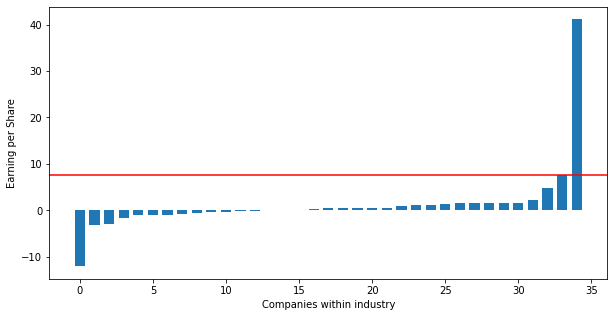

In [13]:
# Graph EPS for industry
industry_eps = np.sort(industry_indicator[:,1])
eps_clean = industry_eps[~np.isnan(industry_eps)]
avg_eps = np.mean(industry_eps)
eps_graph = eps_df[-1]

x = np.arange(len(industry_eps))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.bar(x, industry_eps, 2*width, label='Industry EPS') 
plt.axhline(y= eps_graph, color = 'r')
ax.set_xlabel('Companies within industry')
ax.set_ylabel('Earning per Share')

print('The EPS for',tckr,'is:', round(eps_graph,2), '\nThe Industry PE ratio average is:', round(avg_eps,2) )

plt.show()

The PE ratio for FB is: 19.78 
The Industry PE ratio average is: 18.41


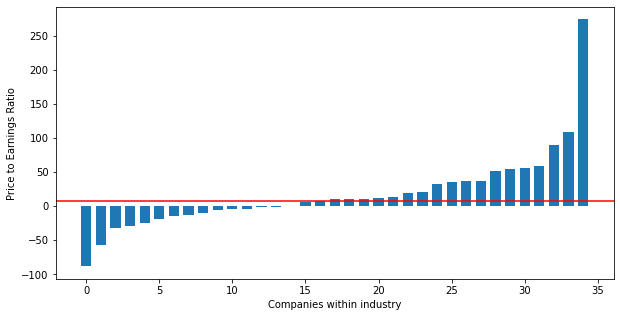

In [14]:
# Graph industry Price to Earning ratio  
industry_pe = np.sort(industry_indicator[:,2])
pe_clean = industry_pe[~np.isnan(industry_pe)]
avg_pe = np.mean(pe_clean)
pe_graph = share_price.loc[tckr]['Close'][0]/eps_graph

x = np.arange(len(industry_pe))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.bar(x, industry_pe, 2*width, label='Industry Price-Earning ratio')
plt.axhline(y= eps_df[-1] , color = 'r')
ax.set_xlabel('Companies within industry')
ax.set_ylabel('Price to Earnings Ratio')

print('The PE ratio for',tckr,'is:', round(pe_graph,2), '\nThe Industry PE ratio average is:', round(avg_pe,2))

plt.show()

The Price-Sales ratio for FB is: 7.83 
The Industry PS ratio average is: 3.28


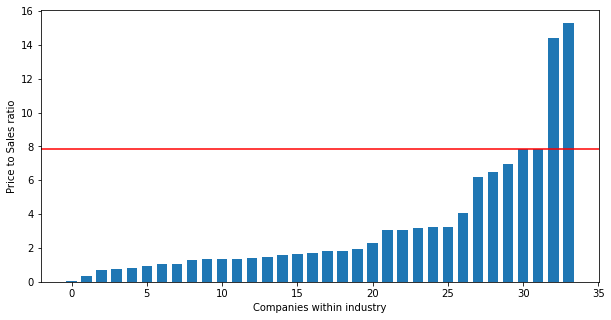

In [15]:
# Graph Price to Sales ratio for industry
industry_ps = np.sort(industry_indicator[:,3])
pe_clean = industry_ps[~np.isinf(industry_ps)]
avg_ps = np.mean(pe_clean)
ps_graph = share_price.loc[tckr]['Close'][0]/(revenue_df[-1]/balance_sheet.loc[tckr]['Shares (Diluted)'][-1])

x = np.arange(len(industry_ps))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
ax3 = ax.bar(x, industry_ps, 2*width, label='Industry Price-Earning ratio')
plt.axhline(y= ps_graph , color = 'r')
ax.set_xlabel('Companies within industry')
ax.set_ylabel('Price to Sales ratio')

print('The Price-Sales ratio for',tckr,'is:', round(ps_graph,2) , '\nThe Industry PS ratio average is:', round(avg_ps,2) )

plt.show()

The Debt-Equity ratio for FB is: nan 
The Industry DE ratio average is: -0.37972030820414204


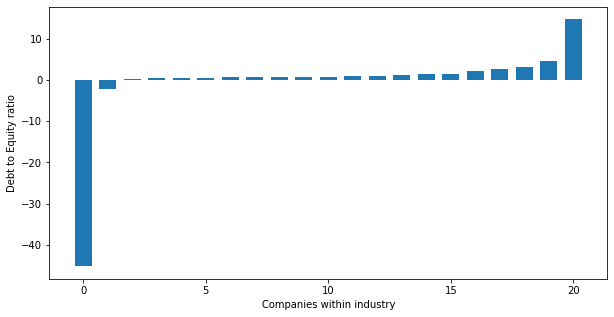

In [16]:
# Graph Debt to Equity ratio for industry
industry_de = np.sort(industry_indicator[:,4])
de_clean = industry_de[~np.isnan(industry_de)]
avg_de = np.mean(de_clean)
de_graph = (balance_sheet.loc[tckr]['Long Term Debt'][-1] + balance_sheet.loc[tckr]['Total Current Assets'][-1])/balance_sheet.loc[tckr]['Total Equity'][-1]

x = np.arange(len(industry_de))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
ax3 = ax.bar(x, industry_de, 2*width, label='Industry Price-Earning ratio')
plt.axhline(y= de_graph, color = 'r')
ax.set_xlabel('Companies within industry')
ax.set_ylabel('Debt to Equity ratio')

print('The Debt-Equity ratio for',tckr,'is:', de_graph , '\nThe Industry DE ratio average is:', avg_de)

plt.show()

## <center> Stage 3 - Basic growth Forecast </center>
<center> Perform a automated discounterd cash flow(DCF) and calculate the required growth rate to hit porfolio target </center>

## Growth forecast
Aswell as analysing the history of the data, we can use it to look forward by forecasting growth. This forecast allows provides useful information which can then be use to validate the decision to buy the stock based on the results found in stage 3.

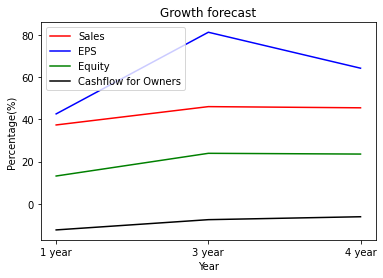

In [17]:
# Calculate the rate of interest of different periods to perform a growth forecast 
sales_1 = np.rate(1,[0],pv=-revenue_df[-2],fv=revenue_df[-1])*100
sales_3 = np.rate(3,[0],pv=-revenue_df[-4],fv=revenue_df[-1])*100
sales_4 = np.rate(4,[0],pv=-revenue_df[-5],fv=revenue_df[-1])*100
sales_growth = [sales_1, sales_3, sales_4]
eps_1 = np.rate(1,[0],pv=-eps_df[-2],fv=eps_df[-1])*100
eps_3 = np.rate(3,[0],pv=-eps_df[-4],fv=eps_df[-1])*100
eps_4 = np.rate(4,[0],pv=-eps_df[-5],fv=eps_df[-1])*100
eps_growth = [eps_1,eps_3, eps_4]
equity_1 = np.rate(1,[0],pv=-equity_df[-2],fv=equity_df[-1])*100
equity_3 = np.rate(3,[0],pv=-equity_df[-4],fv=equity_df[-1])*100
equity_4 = np.rate(4,[0],pv=-equity_df[-5],fv=equity_df[-1])*100
equity_growth = [equity_1, equity_3,equity_4]
cf4o_1 = np.rate(1,[0],pv=-cf4o_df[-3],fv=cf4o_df[-2])*100
cf4o_3 = np.rate(3,[0],pv=-cf4o_df[-5],fv=cf4o_df[-2])*100
cf4o_4 = np.rate(4,[0],pv=-cf4o_df[-6],fv=cf4o_df[-2])*100
cf4o_growth = [cf4o_1,cf4o_3, cf4o_4]
label = ['1 year','3 year', '4 year']

#Plot line graph showing returns
plt.plot(label, sales_growth, 'r-',label='Sales')
plt.plot(label,eps_growth, 'b-',label='EPS')
plt.plot(label,equity_growth,'g-', label = 'Equity')
plt.plot(label,cf4o_growth, 'k-',label ='Cashflow for Owners')
plt.title('Growth forecast')
plt.ylabel('Percentage(%)')
plt.xlabel('Year')
plt.legend()
plt.show()

## Discounted cash flow
In order to calculate the intrinsic value of a  company, a dcf is used. In this instance the expected growth rate of the company is iterated till the intrinsic value is equal to the present value, showing the required growth for it to be viable investment.

In [18]:
# Get input for the specific portfolio
rror = float(input('Enter your porfolio required rate of return(%):')) # Desired portfolio return YOY of 5 years
growth_rate = float(input('Enter starting growth rate:')) #An arbituary value
tgr = 4.0 #Historically between 3.5%-4.5% hence a average is taken for terminal growth rate
y0 = cf4o_df[-2] #Current cashflow for owner

In [19]:
#Calculate the buy price per share using NPV
def buypershare():
    y1 = y0*(1+0.01*growth_rate)
    y2 = y1*(1+0.01*growth_rate)
    y3 = y2*(1+0.01*growth_rate)
    y4 = y3*(1+0.01*growth_rate) 
    y5 = y4*(1+0.01*growth_rate)
    y6 = y5*(1+0.01*growth_rate)
    y7 = y6*(1+0.01*growth_rate)
    y8 = y7*(1+0.01*growth_rate)
    y9 = y8*(1+0.01*growth_rate)
    y10 = y9*(1+0.01*growth_rate)
    cashflow = [y1,y2,y3,y4,y5,y6,y7,y8,y9,y10]
    terminal_buy = (y10*(1+0.01*tgr))/(0.01*(rror-tgr))
    cashflow.append(terminal_buy)
    buy_price = np.npv(rror*0.01,cashflow)
    buy_pershare = buy_price/(shares_out)
    return buy_pershare
#Using steepest descent to determine otpimal growth rate
buy_pershare = float(buypershare())
while int(price) != int(buy_pershare):
    if int(price) > int(buy_pershare):
        growth_rate += 0.05
        buy_pershare = buypershare()
    elif int(price) < int(buy_pershare):
        growth_rate -= 0.05
        buy_pershare = buypershare()
    # print(int(price), int(buy_pershare), growth_rate )
print("The required growth rate to achieve portfolio aim of", rror, ", at current price is:", round(growth_rate,2))

The required growth rate to achieve portfolio aim of 15.0 , at current price is: 14.05
